TBG Model initialized with:
  Twist angle: 0.94°
  Number of Q points: 177
  Hamiltonian size: 354 x 354
  Fermi velocity: 0.6829
  Hopping parameters: u=0.08, u'=0.11

Diagonalizing along K -> Γ -> M -> K' path (with band tracking)...


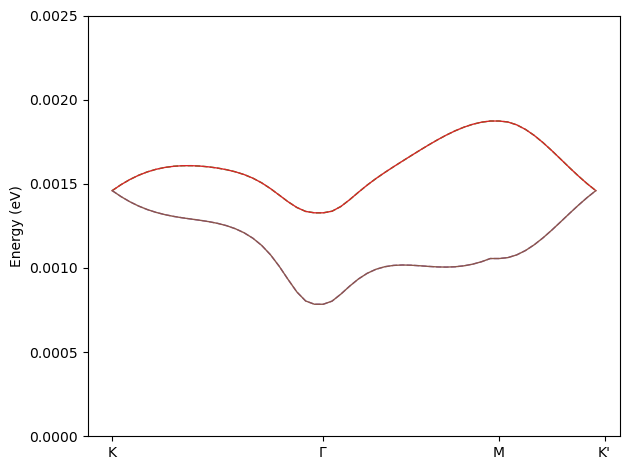

Band structure computed for 56 k-points
Number of bands: 354
Energy range: -1.915 to 1.915 eV


In [2]:
import numpy as np
from numpy.linalg import eigh, norm
import matplotlib.pyplot as plt
from typing import Iterable, List, Sequence, Tuple, Dict

 

def R(x: float) -> np.ndarray:
    """2D rotation matrix."""
    c, s = np.cos(x), np.sin(x)
    return np.array([[c, -s],
                     [s,  c]], dtype=float)

# 2x2 identity
I = np.identity(2, dtype=float)

def Et(theta: float) -> np.ndarray:
    """
    Approximate 'rotation' (antisymmetric) matrix used by the model:
        [[ 0, -theta],
         [theta,  0]]
    """
    return np.array([[0.0,     -theta],
                     [theta,    0.0]], dtype=float)

# ------------------------------------------------
# Reciprocal-lattice (Q-basis) bookkeeping utils
# ------------------------------------------------

def recover_ij_from_Q(
    Q: np.ndarray,
    b: np.ndarray,
    q0: np.ndarray,
    *,
    rtol: float = 1e-8,
    atol: float = 1e-6
) -> List[Tuple[int, int, int]]:
    """
    Recover integers (i, j, l) from rows of Q, where
        k = i*b[0] + j*b[1] - l*q0
    """
    B = np.column_stack((b[0], b[1]))   # 2x2 matrix [b1 b2]
    Binv = np.linalg.inv(B)

    ijl: List[Tuple[int, int, int]] = []
    for row in Q:
        kx, ky, l = row
        k = np.array([kx, ky], dtype=float)
        l = int(round(l))
        v = Binv @ (k + l * q0)  # continuous (i, j)
        ij = np.rint(v).astype(int)
        k_recon = (B @ ij) - l * q0
        if not np.allclose(k_recon, k, rtol=rtol, atol=atol):
            raise ValueError(
                f"Could not reliably recover integer (i,j) from Q row {row}. "
                f"Got fractional {v} -> rounded {ij}; recon {k_recon} vs {k}"
            )
        ijl.append((int(ij[0]), int(ij[1]), l))
    return ijl


def find_opposite_G_pairs(
    Q: np.ndarray,
    b: np.ndarray,
    q: np.ndarray,
    *,
    rtol: float = 1e-8,
    atol: float = 1e-6
) -> List[Tuple[int, int]]:
    """
    Find index pairs (a, b) in Q such that (i, j, l) and (-i, -j, l) correspond
    to opposite reciprocal vectors at the same layer l.
    """
    q0 = q[0]
    ijl = recover_ij_from_Q(Q, b, q0, rtol=rtol, atol=atol)

    # Keep one representative index per (i, j, l).
    buckets: Dict[Tuple[int, int, int], int] = {}
    for idx, (i, j, l) in enumerate(ijl):
        buckets.setdefault((i, j, l), idx)

    pairs: List[Tuple[int, int]] = []
    for (i, j, l), idx_a in buckets.items():
        key_b = (-i, -j, l)
        if key_b in buckets:
            idx_b = buckets[key_b]
            pairs.append((idx_a, idx_b))
    return pairs


def _perm_from_overlap(U_prev: np.ndarray, U_curr: np.ndarray) -> np.ndarray:
    """
    Greedy band-tracking permutation: matches columns of U_curr to those of U_prev
    by maximizing |U_prev^† U_curr|.
    """
    O = np.abs(U_prev.conj().T @ U_curr)  # (nband, nband)
    n = O.shape[0]
    perm = [-1] * n
    used_cols = set()

    # Greedy: pick largest overlap each iteration, invalidate row/col.
    for _ in range(n):
        i, j = divmod(int(O.argmax()), n)
        while j in used_cols:
            O[i, j] = -1.0
            i, j = divmod(int(O.argmax()), n)
        perm[i] = j
        used_cols.add(j)
        O[i, :] = -1.0
        O[:, j] = -1.0

    return np.array(perm, dtype=int)


# -----------------------------
# Twisted bilayer graphene model
# -----------------------------

class TBGModel:
    """
    Minimal BM-like tight-binding-in-Q-space model with moiré couplings,
    written to preserve original behavior/results.
    """

    def __init__(
        self,
        theta: float,
        a: float = 0.246,
        beta: float = 3.14,
        vf: float = 1.3,
        u: float = 0.08,
        up: float = 0.11,
        cut: int = 5
    ):
        # Twist angle in radians
        theta = theta * np.pi / 180.0

        # Store basic params
        self.a = float(a)
        self.beta = float(beta)
        self.theta = float(theta)
        self.A = np.sqrt(3.0) * self.beta / (2.0 * self.a)  # gauge connection

        # Dirac velocity and a few constants as in original
        self.v = vf * 2.1354 * self.a    # vf = 1.3 used in many works
        self.v3 = np.sqrt(3.0) * self.a * 0.32 / 2.0
        self.v4 = np.sqrt(3.0) * self.a * 0.044 / 2.0
        self.gamma1 = 0.4
        self.Dp = 0.05

        self.omega = np.exp(1j * 2.0 * np.pi / 3.0)
        self.u = float(u)
        self.up = float(up)

        # --- Monolayer K vectors
        k_d = 4.0 * np.pi / (3.0 * self.a)
        k1 = np.array([k_d, 0.0], dtype=float)
        k2 = np.array([np.cos(2.0 * np.pi / 3.0) * k_d,
                       np.sin(2.0 * np.pi / 3.0) * k_d], dtype=float)
        k3 = -np.array([np.cos(np.pi / 3.0) * k_d,
                        np.sin(np.pi / 3.0) * k_d], dtype=float)

        # --- Moiré reciprocal vectors
        q1 = Et(self.theta) @ k1
        q2 = Et(self.theta) @ k2
        q3 = Et(self.theta) @ k3
        q = np.array([q1, q2, q3], dtype=float)
        self.q = q
        self.k_theta = float(np.max([norm(q1), norm(q2), norm(q3)]))

        # --- Q-lattice basis
        b1 = q[1] - q[2]
        b2 = q[0] - q[2]
        b3 = q[1] - q[0]
        b = np.array([b1, b2, b3], dtype=float)
        self.b = b

        # --- Generate Q lattice (same bounds/criterion as original)
        Q_list: List[np.ndarray] = []
        for i in range(-100, 100):
            for j in range(-100, 100):
                for l in (0, 1):
                    kvec = np.array([i, j, 0.0], dtype=float) @ b - l * q[0]
                    if norm(kvec) <= np.sqrt(3.0) * self.k_theta * cut:
                        Q_list.append(np.array([kvec[0], kvec[1], float(l)], dtype=float))
        self.Q = np.array(Q_list, dtype=float)
        self.Nq = int(len(self.Q))

        # --- Nearest neighbors on the Q lattice
        #     (preserve the original round+list.index approach to keep behavior identical)
        self.Q_nn: Dict[int, List[Tuple[int, int]]] = {}
        Qxy = np.round(self.Q[:, :2], 3)
        Qxy_list = Qxy.tolist()
        for idx in range(self.Nq):
            nbrs: List[Tuple[int, int]] = []
            for j in range(len(q)):
                tgt = np.round(self.Q[idx, :2] + q[j], 3)
                try:
                    jidx = Qxy_list.index(tgt.tolist())
                    nbrs.append((jidx, j))
                except ValueError:
                    pass
            self.Q_nn[idx] = nbrs

    # keep external helper to preserve behavior
    def find_opposite_G_pairs(self, rtol: float = 1e-8, atol: float = 1e-6) -> List[Tuple[int, int]]:
        return find_opposite_G_pairs(self.Q, self.b, self.q, rtol=rtol, atol=atol)

    def __post_init_deltas(self) -> None:
        """Nearest-neighbor A→B real-space vectors (a = lattice constant, 0.246 nm)."""
        a = self.a
        self.delta_AB = np.array([
            [0.0,          a / np.sqrt(3.0)],        # δ1
            [-a / 2.0,    -a / (2.0 * np.sqrt(3.0))],# δ2
            [ a / 2.0,    -a / (2.0 * np.sqrt(3.0))],# δ3
        ], dtype=float)

    def phi_l(
        self,
        q: np.ndarray,
        l: int,
        *,
        Layer: int = 0,
        xi: int = 1
    ) -> np.ndarray:
        """
        Phase factor used for structure sums (not used by the main spectrum pipeline).
        Implemented to be consistent with current Et signature.
        """
        if not hasattr(self, "delta_AB"):
            self.__post_init_deltas()

        q = np.asarray(q, float)
        was_1d = (q.ndim == 1)
        q = q.reshape(-1, 2)

        w = self.omega
        l = int(l) % 3
        t = 2 * int(Layer) - 1

        # Use the same 'antisymmetric rotation' style as elsewhere
        M = Et(t * xi * self.theta / 2.0)
        A = np.eye(2) + M  # small deformation

        d1, d2, d3 = (A.T @ self.delta_AB[0],
                      A.T @ self.delta_AB[1],
                      A.T @ self.delta_AB[2])

        val = (np.exp(-1j * (q @ d1)) +
               (w**l)    * np.exp(-1j * (q @ d2)) +
               (w**(2*l))* np.exp(-1j * (q @ d3)))
        return val[0] if was_1d else val

    def gen_ham(self, kx: float, ky: float, xi: int = 1) -> np.ndarray:
        """
        Build the 2*Nq x 2*Nq Hamiltonian at momentum (kx, ky) and valley xi.
        Preserves original algebra (including final Hermitian symmetrization).
        """
        k = np.array([kx, ky], dtype=float)

        # Moiré hopping matrices
        U1 = np.array([[self.u, self.up],
                       [self.up, self.u]], dtype=complex)
        U2 = np.array([[self.u, self.up * self.omega**(-xi)],
                       [self.up * self.omega**( xi), self.u]], dtype=complex)
        U3 = np.array([[self.u, self.up * self.omega**( xi)],
                       [self.up * self.omega**(-xi), self.u]], dtype=complex)

        ham = np.zeros((2 * self.Nq, 2 * self.Nq), dtype=complex)

        for i in range(self.Nq):
            t = self.Q[i, 2]
            l = np.sign(2.0 * t - 1.0)  # +1 for layer 1, -1 for layer 0
            M = Et(l * xi * self.theta / 2.0)
            E = (M + M.T) / 2.0
            exx, eyy, exy = E[0, 0], E[1, 1], E[0, 1]

            kj = (I + M) @ (k + self.Q[i, :2] + xi * self.A * np.array([exx - eyy, -2.0 * exy]))
            km = xi * kj[0] - 1j * kj[1]

            # Diagonal 2x2 blocks (off-diagonal entry within sublattice block)
            ham[2 * i, 2 * i + 1] = -self.v * km

            # Off-diagonal moiré couplings
            for (j_idx, p) in self.Q_nn[i]:
                ham[2 * i:2 * i + 2, 2 * j_idx:2 * j_idx + 2] = (
                    (p == 0) * U1 + (p == 1) * U2 + (p == 2) * U3
                )

        # Ensure Hermiticity exactly as in the original
        return ham + ham.conj().T

    # -----------------------------
    # Brillouin-zone path utilities
    # -----------------------------

    def _build_kpath(self, res: int) -> Tuple[np.ndarray, int, int, int]:
        """Construct K → Γ, Γ → M, M → K' path with segment lengths as in original."""
        l1 = int(res)                  # K -> Γ
        l2 = int(np.sqrt(3.0) * res / 2.0)  # Γ -> M
        l3 = int(res / 2.0)            # M -> K'
        kpath: List[np.ndarray] = []

        for i in np.linspace(0.0, 1.0, l1):
            kpath.append(i * (self.q[0] + self.q[1]))
        for i in np.linspace(0.0, 1.0, l2):
            kpath.append(self.q[0] + self.q[1] + i * (-self.q[0] / 2.0 - self.q[1]))
        for i in np.linspace(0.0, 1.0, l3):
            kpath.append(self.q[0] / 2.0 + i * self.q[0] / 2.0)

        return np.array(kpath, dtype=float), l1, l2, l3

    def solve_along_path(
        self,
        res: int = 24,
        *,
        plot_it: bool = True,
        return_eigenvectors: bool = False,
        track_bands: bool = True,
        ylim: Tuple[float, float] | None = (0.03, 0.06)
    ):
        """
        Diagonalize H(k) along a fixed high-symmetry path.
        NOTE: To preserve original results, both 'valleys' are computed with xi=+1,
        just as in the provided script.
        """
        kpath, l1, l2, l3 = self._build_kpath(res)

        evals_m: List[np.ndarray] = []
        evals_p: List[np.ndarray] = []
        evecs_m: List[np.ndarray] = []
        evecs_p: List[np.ndarray] = []

        U_prev_m = None
        U_prev_p = None

        for kx, ky in kpath:
            val_m, vec_m = eigh(self.gen_ham(kx, ky, +1))
            val_p, vec_p = eigh(self.gen_ham(kx, ky, +1))  # (kept as +1 to match original)

            if track_bands and U_prev_m is not None:
                perm_m = _perm_from_overlap(U_prev_m, vec_m)
                val_m = val_m[perm_m]
                vec_m = vec_m[:, perm_m]
                perm_p = _perm_from_overlap(U_prev_p, vec_p)
                val_p = val_p[perm_p]
                vec_p = vec_p[:, perm_p]

            U_prev_m, U_prev_p = vec_m, vec_p
            evals_m.append(val_m)
            evals_p.append(val_p)
            if return_eigenvectors:
                evecs_m.append(vec_m)
                evecs_p.append(vec_p)

        evals_m = np.vstack(evals_m)
        evals_p = np.vstack(evals_p)

        if plot_it:
            plt.figure(1)
            plt.clf()
            nband = evals_m.shape[1]
            for i in range(nband):
                plt.plot(evals_m[:, i], linestyle='dashed', linewidth=1.0)
                plt.plot(evals_p[:, i], linewidth=1.0)
            if ylim is not None:
                plt.ylim(*ylim)
            plt.xticks([0, l1, l1 + l2, l1 + l2 + l3], ['K', r'$\Gamma$', 'M', "K'"])
            plt.ylabel('Energy (eV)')
            plt.tight_layout()
            plt.show()

        if return_eigenvectors:
            return evals_m, evals_p, np.array(evecs_m), np.array(evecs_p), kpath
        else:
            return evals_m, evals_p, kpath


# -----------------------------
# Script entry point
# -----------------------------

if __name__ == "__main__":
    magic_angle = 0.94  # degrees

    tbg = TBGModel(magic_angle)

    print("TBG Model initialized with:")
    print(f"  Twist angle: {magic_angle}°")
    print(f"  Number of Q points: {tbg.Nq}")
    print(f"  Hamiltonian size: {2*tbg.Nq} x {2*tbg.Nq}")
    print(f"  Fermi velocity: {tbg.v:.4f}")
    print(f"  Hopping parameters: u={tbg.u}, u'={tbg.up}")

    print("\nDiagonalizing along K -> Γ -> M -> K' path (with band tracking)...")
    evals_m, evals_p, kpath = tbg.solve_along_path(res=24, track_bands=True, ylim=(0.0, 0.0025))

    print(f"Band structure computed for {len(kpath)} k-points")
    print(f"Number of bands: {evals_m.shape[1]}")
    print(f"Energy range: {evals_m.min():.3f} to {evals_m.max():.3f} eV")


In [ ]:
import numpy as np
from numpy.linalg import eigh
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional


class SmoothTracker:
    
    ## Important. Remember Prevoius State
    def __init__(self, eps_deg: float = 1e-5):
        self.U_prev: Optional[np.ndarray] = None
        self.e_prev: Optional[np.ndarray] = None
        self.eps_deg = eps_deg

    @staticmethod
    def _hungarian_match(U_prev, U_curr):
        O = np.abs(U_prev.conj().T @ U_curr)
        rows, cols = linear_sum_assignment(1.0 - O)
        # linear_sum_assignment minimize the cost function \sum_i 1- O_{i,\pi(i)}
        # So one can find correct cols.
        return cols
    
    
    def _deg_blocks(self, e):
        e = np.asarray(e, float)
        n = e.size
        if n == 0: return []
        blocks = []
        i = 0
        while i < n:
            j = i + 1
            while j < n and abs(e[j] - e[i]) <= self.eps_deg * max(1.0, abs(e[i])):
                j += 1
            blocks.append(np.arange(i, j))
            i = j
        return blocks

    def align(self, e_curr, U_curr):
        #
        if self.U_prev is None:
            e = np.asarray(e_curr).copy()
            U = np.asarray(U_curr, complex).copy()
            ##
            for b in range(U.shape[1]):
                col = U[:, b]
                m = np.argmax(np.abs(col))
                ###
                if np.abs(col[m]) > 0:
                    phase=col[m] / np.abs(col[m]);
                    U[:, b] /= phase;
                ###
            self.e_prev, self.U_prev = e, U
            return e, U

        # 1) match bands
        
        # return permutation index
        perm = self._hungarian_match(self.U_prev, U_curr) 
        e = np.asarray(e_curr)[perm]  ## Perform Permuations.
        U = np.asarray(U_curr, complex)[:, perm]

        # 2) align within degenerate blocks
        for blk in self._deg_blocks(e):
            if np.size(blk) == 1:
                t = int(blk[0])                           # global band index
                ov = self.U_prev[:, t].conj().T @ U[:, t] # complex overlap
                if np.abs(ov) > 0:
                    U[:, t] /= ov / np.abs(ov)            # make overlap real-positive
                continue

            Up = self.U_prev[:, blk]  # (dim, m)
            Uc = U[:, blk]            # (dim, m)
            M = Up.conj().T @ Uc
            L, _, Rh = np.linalg.svd(M, full_matrices=False)
            W = Rh.conj().T @ L.conj().T
            U[:, blk] = Uc @ W
            # parallel-transport (positive-real overlap)
            
            for t in range(len(blk)):
                ov = Up[:, t].conj().T @ U[:, blk[t]]
                if ov != 0:
                    U[:, blk[t]] /= ov/abs(ov)

        self.e_prev, self.U_prev = e, U
        return e, U


def compute_Lambda_smooth(tbg,k,Layer,Sym,pairs,tracker_plus,tracker_minus):
    ##
    k = np.asarray(k, float).reshape(2,)
    kx, ky = k
    #
      
    #The value of COM depends on pairing momentum relative to picked Origin 
    COM=tbg.q[0]+tbg.q[1];    # Here we pick Gamma point
    # 
    H_plus  = np.asarray(tbg.gen_ham(kx+COM[0],  ky+COM[1]))   
    H_minus = np.asarray(tbg.gen_ham(-kx+COM[0], -ky+COM[1]))
    e_plus,  U_plus  = eigh(H_plus)
    e_minus, U_minus = eigh(H_minus)

    # trackers
    if tracker_plus  is None:  tracker_plus  = SmoothTracker()
    if tracker_minus is None:  tracker_minus = SmoothTracker()
    e_plus,  U_plus  = tracker_plus.align(e_plus,  U_plus)
    e_minus, U_minus = tracker_minus.align(e_minus, U_minus)

    M = U_plus.shape[1]

    # pairs on chosen Layer
    
    pairs_L = [(a, b) for (a, b) in pairs
               if int(round(tbg.Q[a, 2])) == Layer and int(round(tbg.Q[b, 2])) == Layer]
    
    # First/Second index of Pair; 
    idx_a = np.fromiter((a for a, _ in pairs_L), dtype=int)
    idx_b = np.fromiter((b for _, b in pairs_L), dtype=int)

    # rows for A/B sublattices

    rows_a = 2*idx_a + 0;
    rows_b = 2*idx_b + 1;  

    V_plus  = np.take(U_plus,  rows_a, axis=0)   # (P, M)
    V_minus = np.take(U_minus, rows_b, axis=0)   # (P, M)

    #  
    q0 = np.asarray(tbg.q[0], float).reshape(2,);    
    Gs = Layer * q0+np.asarray(tbg.Q[idx_a, :2], float) 
    phases = np.conj(np.asarray(tbg.phi_l(Gs + k[None, :], Sym, Layer, xi=1))).reshape(-1)

    P = phases.size
    if V_plus.shape != (P, M) or V_minus.shape != (P, M):
        raise ValueError(
            f"Shape mismatch: phases {phases.shape}, V_plus {V_plus.shape}, V_minus {V_minus.shape}, M {M}"
        )

    #
    Lambda = V_plus.T @ (phases[:, None] * V_minus)
    return Lambda, e_plus, e_minus, tracker_plus, tracker_minus


 
def serpentine_masked_indices(mask):
    H, W = mask.shape
    for i in range(H):
        js = np.flatnonzero(mask[i])
        if i % 2: js = js[::-1]
        for j in js:
            yield i, j

def hex_bz_mesh(b1, b2, N=10,mode ='six'):
    tol=1e-12
    b1 = np.asarray(b1, float); b2 = np.asarray(b2, float)
    B = np.column_stack([b1, b2]); BinvT = np.linalg.inv(B.T)
    b1sq, b2sq = np.dot(b1, b1), np.dot(b2, b2)

    rng = np.arange(-N, N + 1)
    I, J = np.meshgrid(rng, rng, indexing='ij')
    c1 = I / N; c2 = J / N

    if mode == 'six':
        mask = (np.abs(c1) <= 1 + tol) & (np.abs(c2) <= 1 + tol) & (np.abs(c1 + c2) <= 1 + tol)
    elif mode == 'none':
        mask = (np.abs(c1) <  1 - tol) & (np.abs(c2) <  1 - tol) & (np.abs(c1 + c2) <  1 - tol)
    elif mode == 'three_alternating':
        # keep:  c1 = -1, c2 = -1, c1+c2 = +1
        # drop:  c1 = +1, c2 = +1, c1+c2 = -1  (strict)
        mask = (c1 >= -1 - tol) & (c1 <  1 - tol) & \
               (c2 >= -1 - tol) & (c2 <  1 - tol) & \
               (c1 + c2 <= 1 + tol) & (c1 + c2 > -1 + tol)
        # => all 6 vertices are excluded (each sits on one dropped edge)
    elif mode == 'three_consecutive':
        # keep:  c1 = -1, c2 = -1, c1+c2 = -1  (inclusive)
        # drop:  c1 = +1, c2 = +1, c1+c2 = +1  (strict)
        mask = (c1 >= -1 - tol) & (c2 >= -1 - tol) & (c1 + c2 >= -1 - tol) & \
               (c1 <  1 - tol) & (c2 <  1 - tol) & (c1 + c2 <  1 - tol)
        # => includes exactly two vertices: (-1,0) and (0,-1)
    else:
        raise ValueError("mode must be 'six', 'none', 'three_alternating', or 'three_consecutive'")

    c1v = c1[mask].ravel()
    c2v = c2[mask].ravel()
    s = np.vstack([0.5 * b1sq * c1v, 0.5 * b2sq * c2v])  # [k·b1, k·b2]
    kpts = (BinvT @ s).T
    idx_map = -np.ones(mask.shape, dtype=int)
    idx_map[mask] = np.arange(mask.sum(), dtype=int)
    return kpts, mask, idx_map

import os
import numpy as np
from numpy.linalg import norm, eigh

#
OUT_DIR = "lambda_dump"
 
# 
def ensure_dir(path):
    if not os.path.isdir(path):
        os.makedirs(path, exist_ok=True)

def save_lambda_npz(basepath, k, layer, sym, Lambda, evals_plus, evals_minus):
    np.savez_compressed(basepath + ".npz",k=np.asarray(k, float),
        layer=int(layer),sym=int(sym),Lambda=Lambda,
        evals_plus=np.asarray(evals_plus, float),
        evals_minus=np.asarray(evals_minus, float),
    )

def save_lambda_csv_pair(basepath, Lambda):
    # CSVs for real/imag separately (compact and easy to reload)
    np.savetxt(basepath + "_real.csv", np.real(Lambda), delimiter=",")
    np.savetxt(basepath + "_imag.csv", np.imag(Lambda), delimiter=",")

def dump_all_Lambdas_smooth(tbg,b1,b2,N1,*,out_dir=OUT_DIR,eps_deg=1e-5):
    
    #
    ensure_dir(out_dir)
    pairs = tbg.find_opposite_G_pairs()
    Gamma=tbg.q[0]+tbg.q[1]; 
    # fix a smooth order
    kpts_cart, mask, idx_map=hex_bz_mesh(b1, b2, N1,mode = 'six')
    order = [idx_map[i, j] for i, j in serpentine_masked_indices(mask)]

    # write index of k points
    index_path = os.path.join(out_dir, "k_index.csv")
    with open(index_path, "w") as fidx:
        fidx.write("k_index,kx,ky\n")
        for new_i, flat_i in enumerate(order):
            k = kpts_cart[flat_i]
            fidx.write(f"{new_i},{k[0]},{k[1]}\n")


    summary_path = os.path.join(out_dir, "summary.csv")
    with open(summary_path, "w") as fs:
        fs.write("k_index,layer,sym,M,trace_abs,max_abs\n")

        trackers = {}
        for layer in (0, 1):
            for sym in (0,2):
                trackers[(layer, sym)] = (SmoothTracker(eps_deg=eps_deg),
                                          SmoothTracker(eps_deg=eps_deg))

        
        for new_i, flat_i in enumerate(order):
            k = np.asarray(kpts_cart[flat_i], float).reshape(2,)
            #Compute 
            for layer in (0, 1):
                for sym in (0,2):
                    
                    tr_p, tr_m = trackers[(layer, sym)]
                    #  
                    Lambda, evals_plus, evals_minus, tr_p, tr_m = compute_Lambda_smooth(
                        tbg, k,Layer=layer,Sym=sym,pairs=pairs,
                        tracker_plus=tr_p,tracker_minus=tr_m,
                    )
                    # persist updated trackers
                    trackers[(layer, sym)] = (tr_p, tr_m)
                    ##
                    M = Lambda.shape[0]
                    base = os.path.join(out_dir, f"k{new_i:05d}_L{layer}_S{sym}")

                    # compact binary (recommended)
                    save_lambda_npz(base, k, layer, sym, Lambda, evals_plus, evals_minus)


                    # quick metrics
                    fs.write("{},{},{},{},{:.6e},{:.6e}\n".format(
                        new_i, layer, sym, M,
                        float(np.abs(np.trace(Lambda))),
                        float(np.max(np.abs(Lambda)))
                    ))

 

b1 = tbg.q[0] - tbg.q[1]
b2 = tbg.q[2] - tbg.q[0]
N1=21;
 
# Use serpentine traversal for smoother tracking across the mesh
dump_all_Lambdas_smooth(
    tbg, b1, b2, N1,
    out_dir="lambda_dump",
    eps_deg=1e-5)

print("Done. Files in ./lambda_dump")